# Import 

In [3]:
import tensorflow_datasets as tfds

In [14]:
# import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, 
    Dense,
    Flatten,
    Reshape,
    LeakyReLU,
    Dropout,
    UpSampling2D
)
import keras
import tensorflow.keras.backend as K
import numpy as np

In [15]:
# Check GPU
import tensorflow as tf
# import keras
gpus = tf.config.experimental.list_physical_devices("GPU")
for each in gpus:
    tf.config.experimental.set_memory_growth(each, True)

In [16]:
# Check keras
keras.__version__

'2.15.0'

In [18]:
# Dataset
ds = tfds.load('fashion_mnist', split='train')

In [19]:
ds.as_numpy_iterator().next()["label"]

2024-03-26 14:10:30.155306: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2

# Viz data and build dataset

In [20]:
# import numpy as np

In [21]:
dataiterator = ds.as_numpy_iterator()

In [22]:
dataiterator.next()["image"]

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

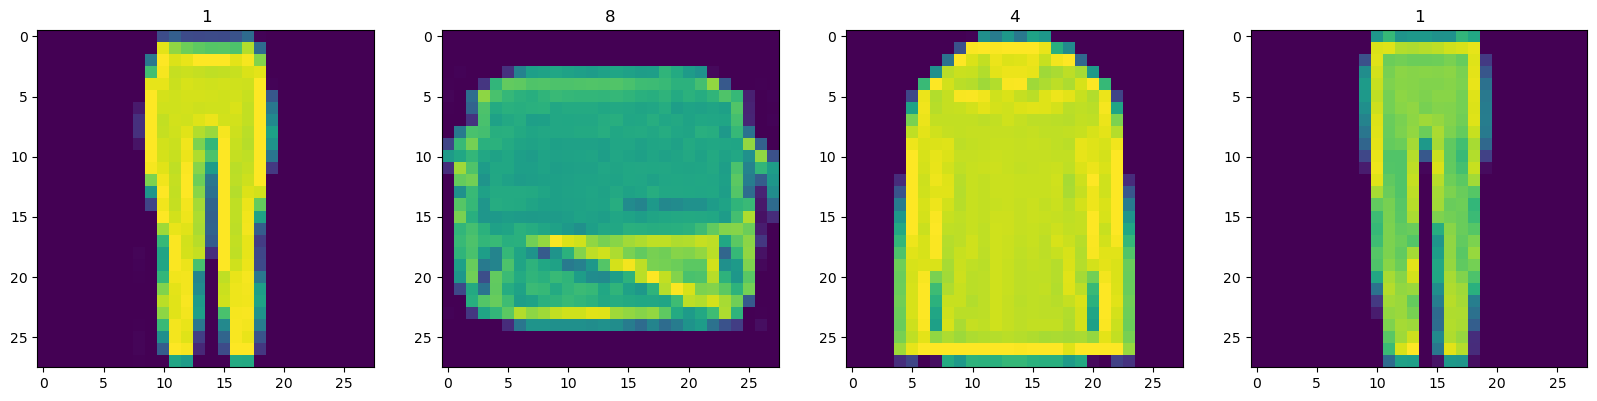

In [23]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [24]:
def scale_imgs(data):
    image = data["image"]
    return image/255

In [25]:
ds = tfds.load("fashion_mnist", split="train")
ds = ds.map(scale_imgs)
ds = ds.cache() # cache the dataset for the batch
ds = ds.shuffle(60000)
ds = ds.batch(128) # batch into 128 imgs per sample
"""
The prefetch parameter allows you to control the number of batches 
to prefetch from the dataset, leading to improved training 
performance.
"""
ds = ds.prefetch(64) # reducing the likelihood of bottlenecking

In [26]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Build neural network

In [27]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (
#     Conv2D, 
#     Dense,
#     Flatten,
#     Reshape,
#     LeakyReLU,
#     Dropout,
#     UpSampling2D
# )

In [28]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [29]:
generator = build_generator()

In [30]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [31]:
# test for image generation
img = generator.predict(np.random.randn(4,128))

2024-03-26 14:10:36.451162: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


1/1 [==============================] - 1s 709ms/step


In [32]:
img.shape

(4, 28, 28, 1)

In [33]:
np.random.randn(4,128).size, np.random.randn(4,128).shape, np.random.randn(4,128).ndim

(512, (4, 128), 2)

In [34]:
np.random.randn(4,128,1).ndim,

(3,)

1/1 [==============================] - 0s 23ms/step
(28, 28) (28, 28, 1)
(28, 28) (28, 28, 1)
(28, 28) (28, 28, 1)
(28, 28) (28, 28, 1)


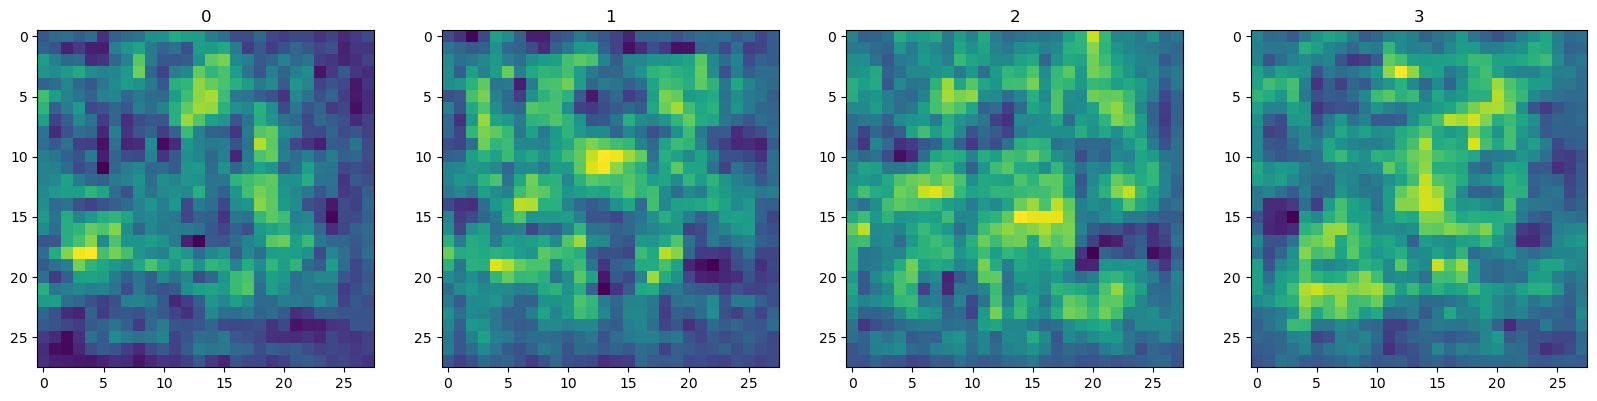

In [35]:
img = generator.predict(np.random.randn(4,128))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for inx, img in enumerate(img):
    print(np.squeeze(img).shape, img.shape)
#     ax[inx].imshow(np.squeeze(img))
    ax[inx].imshow(img)
    ax[inx].title.set_text(inx)
    

In [36]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape=(28,28,1)))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))
    
    # Flatten the pass to dense layer
    model.add(Flatten())
    model.add(Dropout(.4))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [37]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [38]:
img = generator.predict(np.random.randn(4,128))
img.shape

1/1 [==============================] - 0s 18ms/step


(4, 28, 28, 1)

In [39]:
img_gen = discriminator.predict(img)
img_gen.shape

1/1 [==============================] - 0s 245ms/step


(4, 1)

In [40]:
img_gen

array([[0.50228685],
       [0.5022458 ],
       [0.5021586 ],
       [0.50220925]], dtype=float32)